# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import model_selection, ensemble, neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier

import inflection

from IPython.display            import Image
from IPython.core.display       import HTML

import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [2]:
## performance metrics

# definition of precision_at_k for the top 20.000 clients as default
def precision_at_k (data, k=2000):
    
    # reset index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    #calculate precision based on column named response
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

# definition of recall_at_k for the top 20.000 clients as default
def recall_at_k (data, k=2000):
    
    # reset index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    #calculate recall based on the sum of responses
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


## Loading Data 

In [3]:
df_raw = pd.read_csv('data/train.csv')

# Data Details

In [4]:
df2 = df_raw.copy()

In [5]:
df2.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Data Dictionary

|The data set that we're using is from Kaggle (https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction).



| Feature                                       |Description   
|:---------------------------|:---------------
| **Id**                         | Unique ID for the customer   | 
| **Gender**                           | Gender of the customer   | 
| **Driving License**                                   | 0, customer does not have DL; 1, customer already has DL  | 
| **Region Code**                               | Unique code for the region of the customer   | 
| **Previously Insured**                     | 1, customer already has vehicle insurance; 0, customer doesn't have vehicle insurance | 
| **Vehicle Age**                     | Age of the vehicle | 
| **Vehicle Damage**                                  | 1, customer got his/her vehicle damaged in the past; 0, customer didn't get his/her vehicle damaged in the past | 
| **Anual Premium**                             | The amount customer needs to pay as premium in the year | 
| **Policy sales channel**                                    | Anonymized Code for the channel of outreaching to the customer ie  | 
| **Vintage**                | Number of Days, customer has been associated with the company  | 
| **Response**              | 1, customer is interested; 0, customer is not interested. |    

## Rename Columns

In [6]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 
            'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df2.columns = cols_new

## Data Dimensions

In [7]:
print ('Number of Rows: {}'.format( df2.shape[0]))
print ('Number of Columns: {}'.format( df2.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## Data Types

In [8]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## Missing Values

In [9]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## Change Types

In [10]:
# changing data types from float to int64

df2['region_code'] = df2['region_code'].astype('int64')     

df2['policy_sales_channel'] = df2['policy_sales_channel'].astype('int64')    

df2['annual_premium'] = df2['annual_premium'].astype('int64')    


## Descriptive Statistics


In [11]:
# Split numerical and categorical features
num_attributes = df2.select_dtypes( include=['int64', 'float64'])
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64'])

### Numerical Attributes

In [12]:
#Central Tendency - mean, meadian
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
m= pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


- Age of customers ranges from 20 to 85 years old, average being close to 38.
- ≈ 100% of the clients in analysis retain a driving license
- ≈ 55% of the clients do not have vehicle insurance
- Clients pay ≈ 30.5k for their current health insurance policy
- 12.23% of the clients showed to be interest in purchasing a vehicle insurance.

### Categorical Attributes

In [13]:
cat_attributes.describe().T

,count,unique,top,freq
gender,381109,2,Male,206089
vehicle_age,381109,3,1-2 Year,200316
vehicle_damage,381109,2,Yes,192413


# Feature Engineering

In [14]:
df3 = df2.copy()

## Features Creation 

In [15]:
# vehicle age
df3['vehicle_age']= df3['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2year' if x== '1-2 Year' else 'between_1_2_year')
# vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

## Mind Map

# Exploratory Data Analysis (EDA)

In [16]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

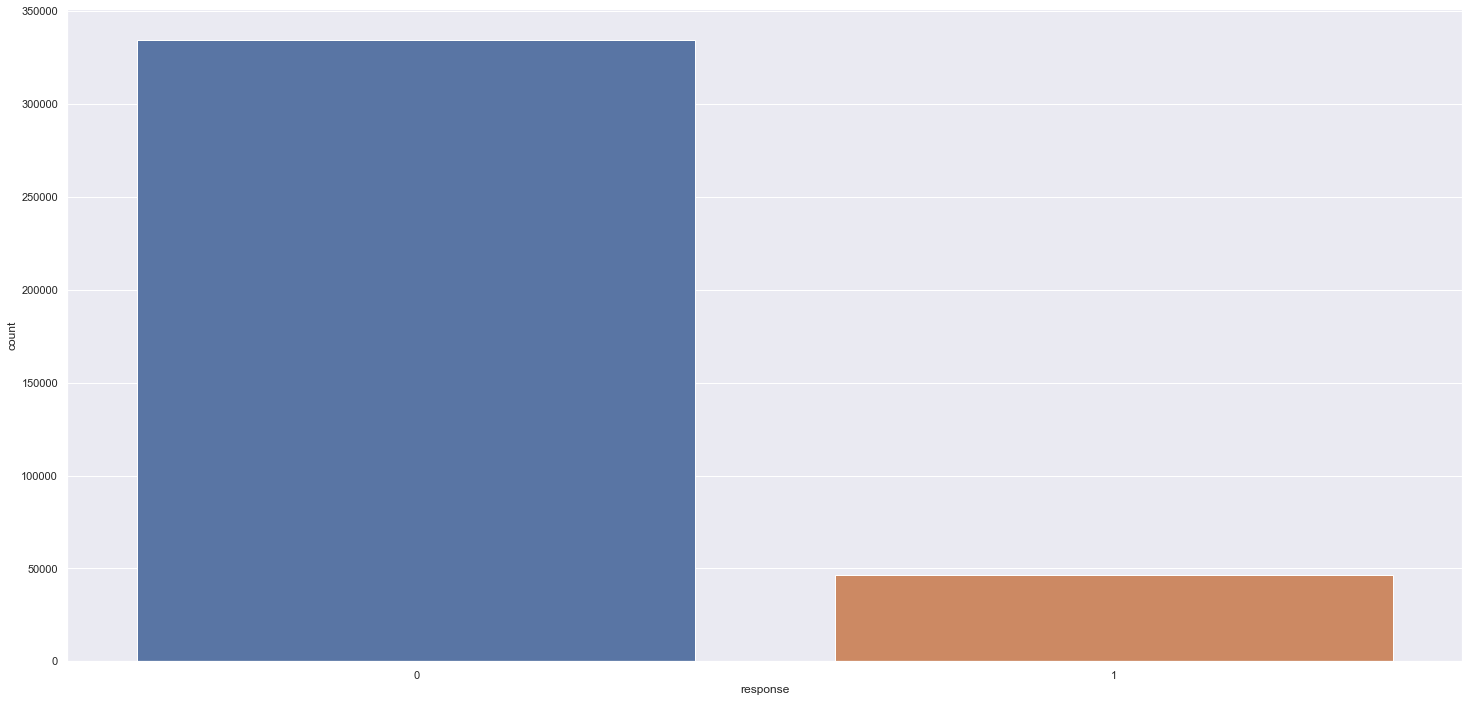

In [17]:
sns.countplot(x = 'response', data=df4);

## Bivariate Analysis

## Multivariate Analysis

# Data Preparation

In [34]:
df5 = df4.copy()

## Data Spliting

In [35]:
df5['annual_premium'] = StandardScaler().fit_transform( df5[['annual_premium']].values)

## Standardization of DataSets 

## Rescaling

In [36]:
mms = MinMaxScaler()

#age
df5['age'] = mms.fit_transform( df5[['age']].values)

#vintage
df5['vintage'] = mms.fit_transform( df5[['vintage']].values)

## Transformation

### Encoding

In [37]:
#gender - target encoder
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Target Encoding - as there are plenty of categories (as seen in EDA) it is better not to use one hot encoding and to use 
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

#vehicle_age
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

#policy_sales_channel - Frequency encode
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len( df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# Feature Selection

In [38]:
df6 = df5.copy()

## Split dataframe into training and test

In [39]:
X = df6.drop('response', axis=1)
y = df6['response'].copy()

x_train, x_val, y_train, y_val = model_selection.train_test_split(X, y, test_size = 0.2)

df6 = pd.concat ( [x_train, y_train], axis = 1)

## Feature Importance

In [40]:
forest = ensemble.ExtraTreesClassifier( n_estimators = 250, random_state = 42, n_jobs = -1)

x_train_n = df6.drop(['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature Rankings
                        feature  importance
0                       vintage    0.274381
0                annual_premium    0.244706
0                           age    0.164492
0                   region_code    0.105397
0                vehicle_damage    0.070944
0          policy_sales_channel    0.061996
0            previously_insured    0.052323
0  vehicle_age_between_1_2_year    0.011852
0   vehicle_age_between_1_2year    0.006102
0                        gender    0.004906
0      vehicle_age_over_2_years    0.002410
0               driving_license    0.000492


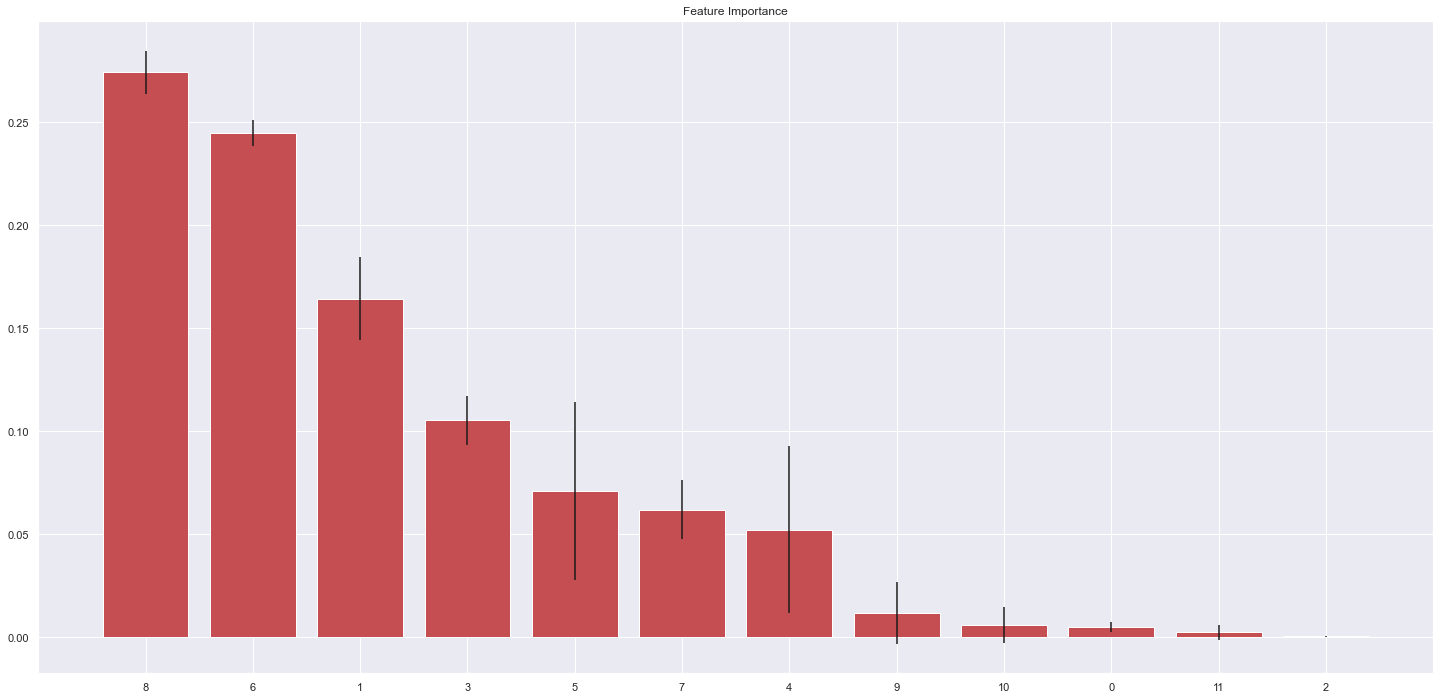

In [41]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]
#print the feature ranking
print( "Feature Rankings")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance':j}, index=[0])
    df = pd.concat ([df, aux], axis = 0)
    
print( df.sort_values( 'importance', ascending=False))

# PLt the impurity-based feature importance of the features
plt.figure()
plt.title('Feature Importance')
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# Machine Learning Modelling

In [44]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                 'vehicle_damage', 'policy_sales_channel']

cols_not_selected = ['previously_insured', 'vehicle_age_between_1_2_year', 'vehicle_age_between_1_2year', 'gender', 'vehicle_age_over_2_years', 'driving_license']

#create df to be used for business understading
x_validation = x_val.drop(cols_not_selected, axis=1)

#create dfs for modeling
x_train = df6[cols_selected]
x_val = x_val[cols_selected]

## KNN Classifier

### Model Building

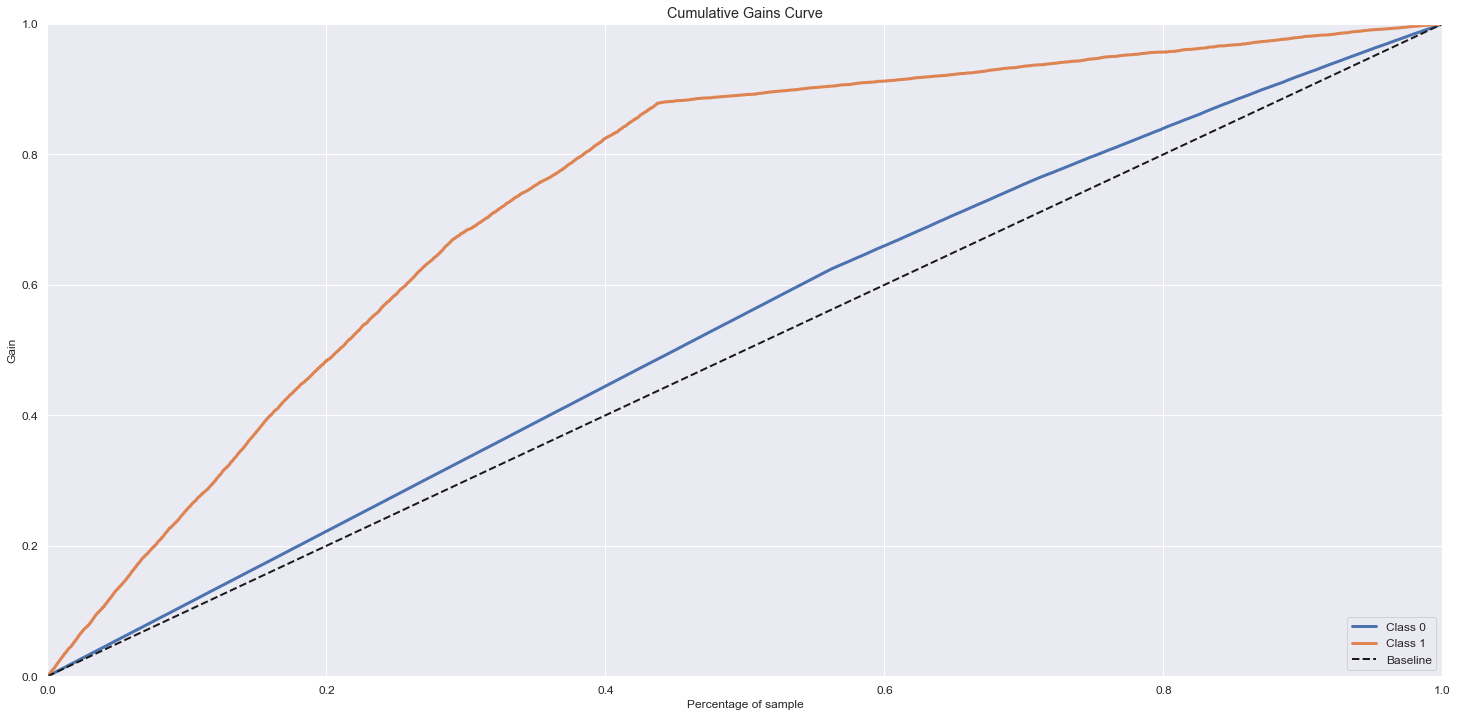

In [49]:
#define model
knn = neighbors.KNeighborsClassifier (n_neighbors = 8)

#train model
knn.fit( x_train, y_train)

#model prediction
yhat_knn = knn.predict_proba( x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

### Model Accuracy

## Extra Trees

### Model Building

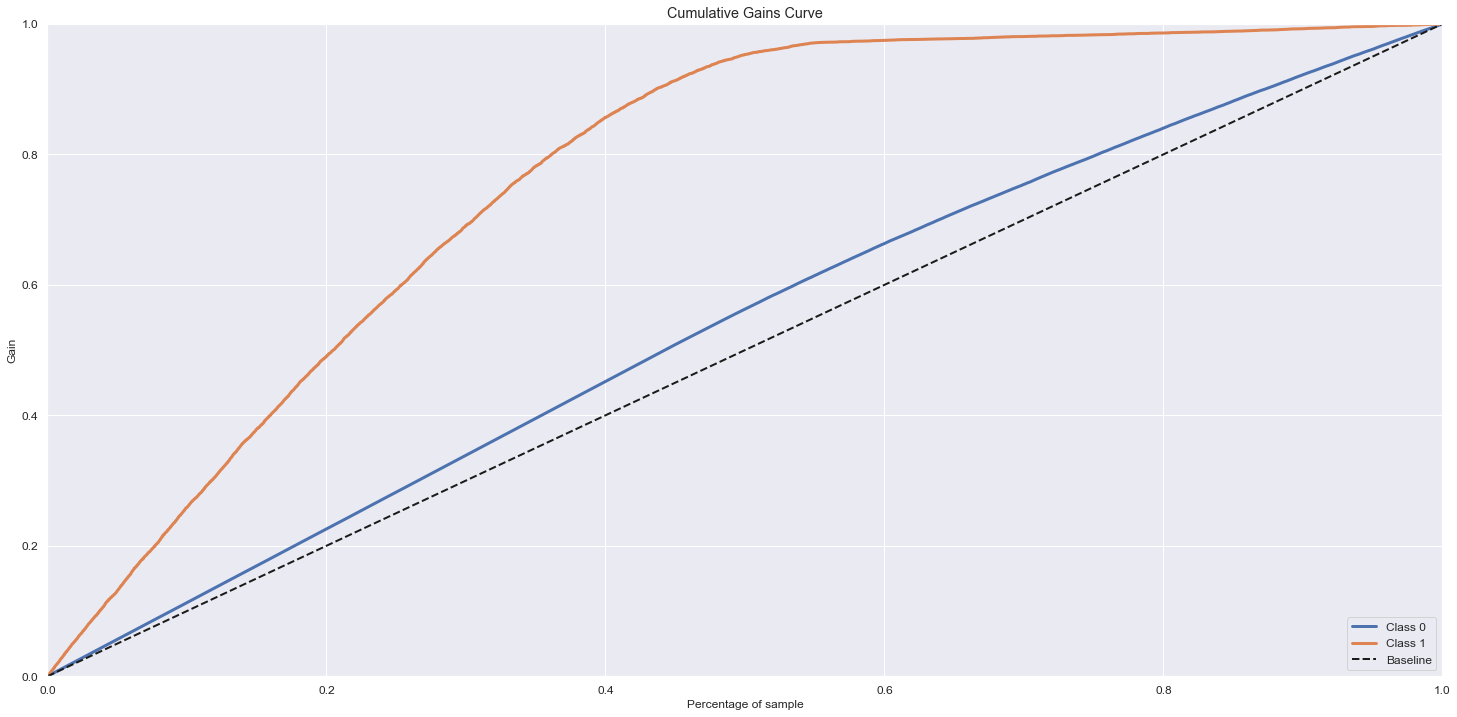

In [28]:
#define model
et = ensemble.ExtraTreesClassifier (n_estimators = 1000, random_state = 42, n_jobs=-1)

#train model
et.fit( x_train, y_train)

#model prediction
yhat_et = et.predict_proba( x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

### Model Accuracy

## Logistic Regression

### Model Building

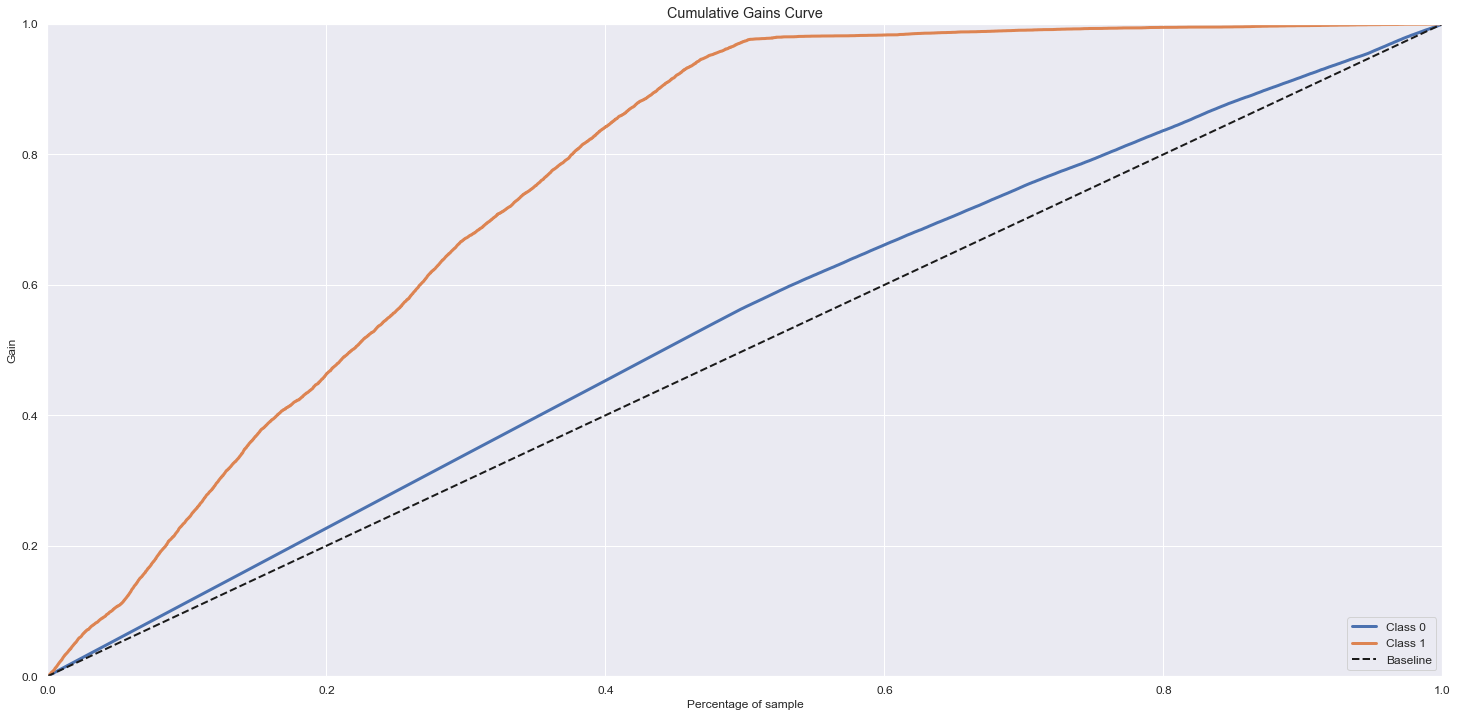

In [29]:
#define model
lr = linear_model.LogisticRegression (random_state = 42)

#train model
lr.fit( x_train, y_train)

#model prediction
yhat_lr = lr.predict_proba( x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

### 7.3.2 Model Accuracy

## Random Forest Regressor

### Model Building

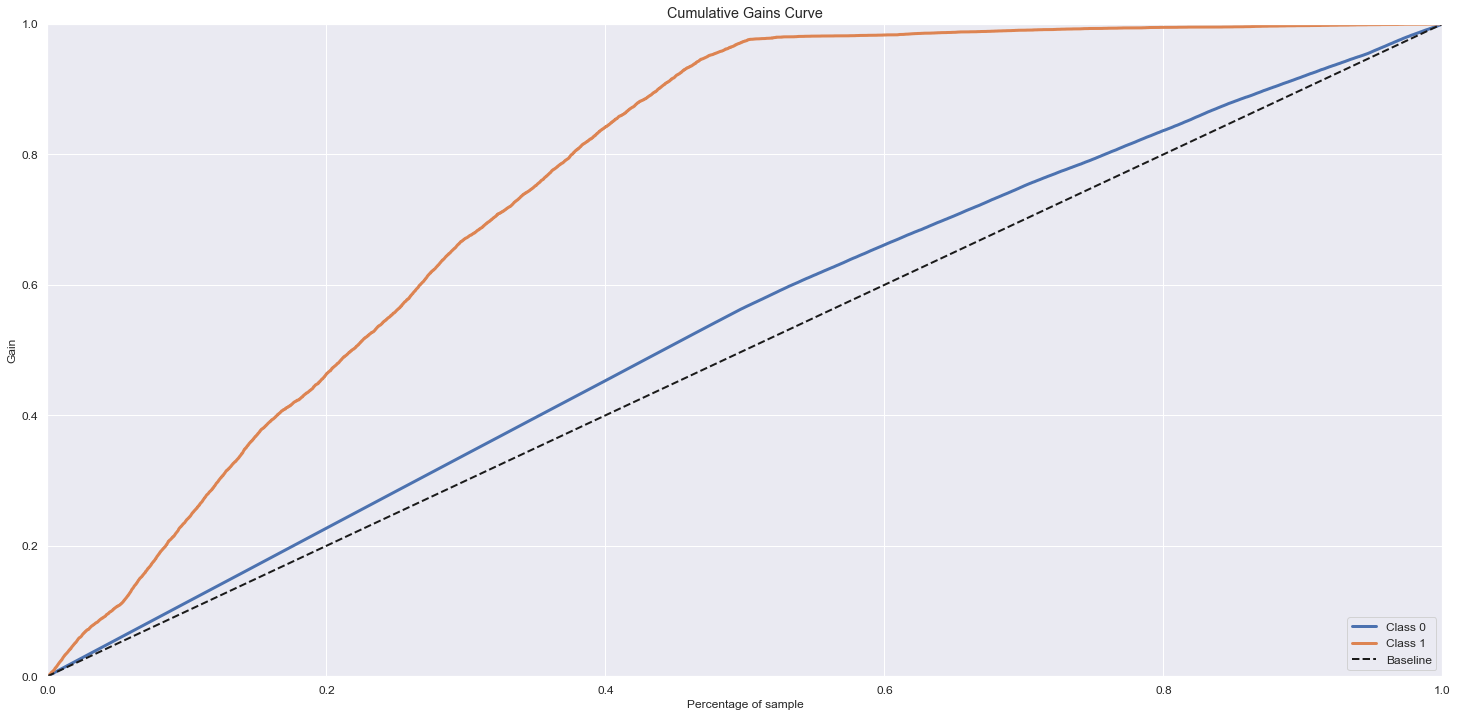

In [30]:
#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=100, min_samples_leaf=25)

#train model
rf.fit( x_train, y_train)

#model prediction
yhat_rf = lr.predict_proba( x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

# Performance Metrics

In [61]:
df8 = x_validation.copy()
df8['response'] = y_val
df8.head()

,id,age,region_code,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
312801,312802,0.338462,0.123362,1,0.600914,0.209127,0.346021,0
180976,180977,0.523077,0.096142,0,-0.194061,0.194157,0.217993,0
82477,82478,0.061538,0.099294,0,0.960814,0.353663,0.044983,0
140563,140564,0.307692,0.081587,1,-1.622853,0.353663,0.031142,0
286179,286180,0.169231,0.127662,0,0.292487,0.353663,0.134948,0


## KNN

In [71]:
# propensity score
df8['score'] = yhat_knn[:,1].tolist()

#sort clients by PS
df8 = df8.sort_values('score', ascending=False)

,id,response,score,ranking,precision_at_k
0,63836,0,1.0,1,0.0
1,24871,0,1.0,2,0.0
2,330701,0,1.0,3,0.0
3,368773,0,1.0,4,0.0
4,378048,0,1.0,5,0.0


In [87]:
#compute precision at k
precision_at_50 = precision_at_k(df8, 50)
print('Precision at K:{}'.format(precision_at_50))

#compute recall at k
recall_at_50 = recall_at_k(df8, 50)
print('Recall at K:{}'.format(recall_at_50))

Precision at K:0.0392156862745098
Recall at K:0.00021179709837975219
